# 📰 어린이 뉴스 EDA

## 1. import

In [1]:
import os
import numpy as np
import pandas as pd
import re
import string
import math

from wordcloud import WordCloud
from textwrap import wrap
from textblob import TextBlob

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font="AppleGothic",
        rc={"axes.unicode_minus":False},
        style='whitegrid')

from matplotlib import rc 
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

## 2. Load the dataset

In [2]:
df = pd.read_csv('./kid_news_20220411.csv',sep='\t', header=0)

## 3. Look at the dataset

In [3]:
df.head()

,news_url,news_title,news_date,news_article
0,http://kid.chosun.com/site/data/html_dir/2022/...,우크라 “전쟁통에도 교육은 계속돼야 한다”… UN도 지원사격,{'$date': '2022-04-07T00:01:00Z'},러시아의 불법적 침공(侵攻)에 따른 국가적 재난에도 불구하고 우크라이나는 미래 세대...
1,http://kid.chosun.com/site/data/html_dir/2022/...,[뉴스탐험대] MS가 뽑은 ‘올해의 亞 스타트업 키워드’는?,{'$date': '2022-04-11T00:01:00Z'},▲ /아이클릭아트 마이크로소프트(MS)가 뽑은 '올해의 아시아 스타트업(Startu...
2,http://kid.chosun.com/site/data/html_dir/2022/...,[뉴스탐험대] “거대 ‘벨리곰’ 보러 가자” 잠실에 50만 명 발길,{'$date': '2022-04-07T00:01:00Z'},지난 1일 롯데월드타워 야외(野外) 잔디 광장에 아파트 4층 높이의 초대형 벨리곰...
3,http://kid.chosun.com/site/data/html_dir/2022/...,[독자·명예기자 학부모에게 물었다] “자가진단 키트 가격 내렸는데 반품·환불 안 되...,{'$date': '2022-04-11T00:01:00Z'},"""반품 어렵다면 처음 구매 가격의 일부라도 환불 원해요."" ""자가검사 후 음성 결과..."
4,http://kid.chosun.com/site/data/html_dir/2022/...,"[뉴스탐험대] “금융, 인생서 꼭 필요한 공부” 중요성 강조",{'$date': '2022-04-11T00:01:00Z'},미국 경제 매체 CNBC는 지난 6일(현지 시각) 개최된 '금융 교육 전략 회의'에...


In [4]:
print(list(df.columns))
print(df.shape)

['news_url', 'news_title', 'news_date', 'news_article']
(1760, 4)


In [5]:
# 데이터 정보를 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   news_url      1760 non-null   object
 1   news_title    1760 non-null   object
 2   news_date     1760 non-null   object
 3   news_article  1760 non-null   object
dtypes: object(4)
memory usage: 55.1+ KB


---

## 4. 데이터 전처리(Data Preprocessing)

### 결측치 확인

In [6]:
# 결측값 확인
df.isnull().sum()

news_url        0
news_title      0
news_date       0
news_article    0
dtype: int64

---

### 문자열 길이 확인 및 추가

In [9]:
df['news_len'] = df['news_article'].apply(lambda x: len(x))

In [10]:
df.head()

,news_url,news_title,news_date,news_article,news_len
0,http://kid.chosun.com/site/data/html_dir/2022/...,우크라 “전쟁통에도 교육은 계속돼야 한다”… UN도 지원사격,{'$date': '2022-04-07T00:01:00Z'},러시아의 불법적 침공(侵攻)에 따른 국가적 재난에도 불구하고 우크라이나는 미래 세대...,809
1,http://kid.chosun.com/site/data/html_dir/2022/...,[뉴스탐험대] MS가 뽑은 ‘올해의 亞 스타트업 키워드’는?,{'$date': '2022-04-11T00:01:00Z'},▲ /아이클릭아트 마이크로소프트(MS)가 뽑은 '올해의 아시아 스타트업(Startu...,504
2,http://kid.chosun.com/site/data/html_dir/2022/...,[뉴스탐험대] “거대 ‘벨리곰’ 보러 가자” 잠실에 50만 명 발길,{'$date': '2022-04-07T00:01:00Z'},지난 1일 롯데월드타워 야외(野外) 잔디 광장에 아파트 4층 높이의 초대형 벨리곰...,373
3,http://kid.chosun.com/site/data/html_dir/2022/...,[독자·명예기자 학부모에게 물었다] “자가진단 키트 가격 내렸는데 반품·환불 안 되...,{'$date': '2022-04-11T00:01:00Z'},"""반품 어렵다면 처음 구매 가격의 일부라도 환불 원해요."" ""자가검사 후 음성 결과...",958
4,http://kid.chosun.com/site/data/html_dir/2022/...,"[뉴스탐험대] “금융, 인생서 꼭 필요한 공부” 중요성 강조",{'$date': '2022-04-11T00:01:00Z'},미국 경제 매체 CNBC는 지난 6일(현지 시각) 개최된 '금융 교육 전략 회의'에...,471


In [11]:
# min 값을 봤을 때 기사가 짧은 경우 존재
df.describe().T

,count,mean,std,min,25%,50%,75%,max
news_len,1760.0,997.163068,713.582501,16.0,487.0,775.5,1228.0,9741.0


---

### 이상치 확인
- 이상한 뉴스 데이터 확인

In [12]:
# 기사 길이 200 이하 확인
condition = (df.news_len <= 200)

shorts_df = df[condition][['news_title','news_url','news_len']].sort_values(by='news_len' ,ascending=True)
shorts_df

,news_title,news_url,news_len
798,[생생~~영상뉴스] 머리에 밥솥 달린 로봇 이야기,http://kid.chosun.com/site/data/html_dir/2021/...,16
457,[생생 인터뷰 현장!] 주한 프랑스 대사 '필립 르포르'를 만나다!,http://kid.chosun.com/site/data/html_dir/2021/...,22
789,[생생~~영상뉴스] 환경파괴의 주범 누텔라?,http://kid.chosun.com/site/data/html_dir/2021/...,27
793,잠자리 드론과 풍선 망원경? 과감한 박새의 사연은?,http://kid.chosun.com/site/data/html_dir/2021/...,28
918,"[동영상]""니네 집에 요리로봇 있어? 비서로봇은?""...""로봇 몇 대 있니?"" 묻는...",http://kid.chosun.com/site/data/html_dir/2021/...,49
391,"[정답 공개] 크리스마스 퍼즐, 숨은그림찾기",http://kid.chosun.com/site/data/html_dir/2021/...,49
201,[꿀BeeTV] 출동! 명예기자 충주 기상과학관에 가다!,http://kid.chosun.com/site/data/html_dir/2022/...,55
256,신자영의 5분 영어!,http://kid.chosun.com/site/data/html_dir/2022/...,59
687,[POPCORN NEWS] 국군의 날 특집! 영상뉴스,http://kid.chosun.com/site/data/html_dir/2021/...,64
124,[꿀BeeTV] 대통령 기록관에 가다!,http://kid.chosun.com/site/data/html_dir/2022/...,66


In [13]:
shorts_df.shape

(25, 3)

In [14]:
short_title = shorts_df.news_title
list(short_title)

['[생생~~영상뉴스] 머리에 밥솥 달린 로봇 이야기',
 "[생생 인터뷰 현장!] 주한 프랑스 대사 '필립 르포르'를 만나다!",
 '[생생~~영상뉴스] 환경파괴의 주범 누텔라?',
 '잠자리 드론과 풍선 망원경? 과감한 박새의 사연은?',
 '[동영상]"니네 집에 요리로봇 있어? 비서로봇은?"..."로봇 몇 대 있니?" 묻는 세상 온다!',
 '[정답 공개] 크리스마스 퍼즐, 숨은그림찾기',
 '[꿀BeeTV] 출동! 명예기자 충주 기상과학관에 가다!',
 '신자영의 5분 영어!',
 '[POPCORN NEWS] 국군의 날 특집! 영상뉴스',
 '[꿀BeeTV] 대통령 기록관에 가다!',
 '간편하게 한 끼 챙길 땐 쫀득쫀득 그래놀라 바',
 "편하게 들고 '쏙쏙' 한입 토스트 꼬치",
 '노릇하게 구워볼까? 폭신폭신 팬케이크',
 '[메시지 뉴스] 세상 가장 작은 나라들',
 '[카드뉴스] "취미활동 늘었지만, 친구 못만나 속상해요"',
 '돌돌 말렸네! 맛있는 시금치 롤',
 "[꿀BeeTV] '알리와 아브라함' 형제 이야기",
 '[#꿀BeeTV_신자영의5분영어] 퇴사할 뻔한 이야기..',
 '[#꿀BeeTV_신자영의5분영어] 사랑했던 아내와 사별한 남자',
 '[#꿀BeeTV_신자영의5분영어] 할머니가 전해준 삶의 의미! ',
 '[꿀BeeTV] 무인도에서 극적으로 탈출한 생존자 이야기',
 '[꿀beetv] 대나무와 고사리 그리고 한 남자의 이야기',
 '초콜릿 잼 품은 바나나 크레이프',
 '[꿀BeeTV] 아무리 돈이 많아도 살 수 없는 것은? ',
 '기록, 또 기록… 케이팝에 한계란 없다']

---

### 데이터 삭제
- 시리즈 기사 title과 그 외 text title 확인

In [15]:
# 전체 기사 대상 진행
split_title = []

for title in df.news_title:
    # m = re.search(r'(?<=\[).*(?=\])', title)
    m = re.search(r'\[(.*?)\]', title)
    if m :
        split_title.append(m.group())
    else:
        # sub_text = re.sub(r'[?]',"\?",title)
        split_title.append(title)

In [16]:
df['split_title'] = split_title

In [17]:
df[['split_title']][:10]

,split_title
0,우크라 “전쟁통에도 교육은 계속돼야 한다”… UN도 지원사격
1,[뉴스탐험대]
2,[뉴스탐험대]
3,[독자·명예기자 학부모에게 물었다]
4,[뉴스탐험대]
5,[뉴스탐험대]
6,기자들의 수다
7,[아싸~ 이득!]
8,[반려동물 웃긴 사진전]
9,[기자 수첩]


In [18]:
# 시리즈 기사 유니크 값 체크
count_unique_title = df.split_title.value_counts()
count_unique_title[count_unique_title >= 2]

[뉴스탐험대]                  584
[오늘의 키워드]                 95
기자들의 수다                   81
[팝콘뉴스]                    28
[주목! 정보 레터]               23
[푸른 별, 지구를 지켜라]           15
[ESG 기업 탐방]               14
[의학 정보 쏙쏙, 우리 아이 쑥쑥]      12
[기자 수첩]                   12
[이슬기의 슬기로운 스토리 잡스]        10
[여러분의 생각은?]                8
[기획]                       8
[우리의 보금자리, 놀라운 住居 상식]      7
[세상 속으로]                   7
[사진으로 보는 세상]               7
[알차고 통통튀는 인터뷰]             7
[꿀BeeTV]                   5
[호국 보훈의 달 특집]              5
[현장]                       5
[탄소 중립 기획]                 4
[초등 트렌드]                   4
[출동! 명예기자]                 4
[알립니다]                     3
[#꿀BeeTV_신자영의5분영어]         3
[초등 줌터뷰]                   3
[현장 스케치]                   3
간추린 소식                     2
[독자·명예기자 학부모에게 물었다]        2
[현장 취재]                    2
[생생~~영상뉴스]                 2
[뉴스타그램]                    2
[포토뉴스]                     2
Name: split_title, dtype: int64

In [19]:
# 200줄 이하 기사 대상 진행

split_title = []

for title in short_title:
    m = re.search(r'\[(.*?)\]', title)
    if m :
        split_title.append(m.group())
    else:
        split_title.append(title)

In [20]:
list(set(split_title))

['[생생 인터뷰 현장!]',
 '[메시지 뉴스]',
 '신자영의 5분 영어!',
 '[#꿀BeeTV_신자영의5분영어]',
 '[정답 공개]',
 '[꿀beetv]',
 '기록, 또 기록… 케이팝에 한계란 없다',
 "편하게 들고 '쏙쏙' 한입 토스트 꼬치",
 '[POPCORN NEWS]',
 '[생생~~영상뉴스]',
 '노릇하게 구워볼까? 폭신폭신 팬케이크',
 '[꿀BeeTV]',
 '간편하게 한 끼 챙길 땐 쫀득쫀득 그래놀라 바',
 '[카드뉴스]',
 '돌돌 말렸네! 맛있는 시금치 롤',
 '[동영상]',
 '초콜릿 잼 품은 바나나 크레이프',
 '잠자리 드론과 풍선 망원경? 과감한 박새의 사연은?']

In [21]:
# 전체 기사에 대한 불용어 처리를 진행합니다
print('불용어 처리 전 df 크기:',len(df))

불용어 처리 전 df 크기: 1760


In [22]:
for title in split_title:
    # 불용어 단어가 news_title에 포함되지 않은 데이터를 걸러냅니다
    df = df[df['news_title'].apply(lambda x: title not in x)]
    # 간혹 시리즈 타이틀이 기사 본문 안에서 시작하는 경우도 있습니다
    df = df[df['news_article'].apply(lambda x: title not in x)]

In [23]:
print('불용어 처리 후 df 크기:',len(df))

불용어 처리 후 df 크기: 1735


In [24]:
# 기사의 길이가 300개 아래인 경우 버림
# 문장 요약을 위해 세 문장보다 많은 기사를 확보하기 위함
df = df[df['news_len'] > 300].reset_index(drop=True)
df.head(2)

,news_url,news_title,news_date,news_article,news_len,split_title
0,http://kid.chosun.com/site/data/html_dir/2022/...,우크라 “전쟁통에도 교육은 계속돼야 한다”… UN도 지원사격,{'$date': '2022-04-07T00:01:00Z'},러시아의 불법적 침공(侵攻)에 따른 국가적 재난에도 불구하고 우크라이나는 미래 세대...,809,우크라 “전쟁통에도 교육은 계속돼야 한다”… UN도 지원사격
1,http://kid.chosun.com/site/data/html_dir/2022/...,[뉴스탐험대] MS가 뽑은 ‘올해의 亞 스타트업 키워드’는?,{'$date': '2022-04-11T00:01:00Z'},▲ /아이클릭아트 마이크로소프트(MS)가 뽑은 '올해의 아시아 스타트업(Startu...,504,[뉴스탐험대]


In [25]:
# 초기 데이터 : 1675
print('짧은 기사 처리 후 df 크기:',len(df))

짧은 기사 처리 후 df 크기: 1724


---

### 특수문자 및 공백 제거

In [26]:
def clean_text(text): 
    text = re.sub(r'(\[)(.*?)(\])','',str(text)) # remove [title]
    text = re.sub(r'(\()(.*?)(\))', '', text)  # 소괄호 (세부 설명
    text = re.sub(r'[?!]', '.', text)          # ?! => 마침표 처리
    text = re.sub(r'[\,\·\:\-\_]', ' ', text)  # 문장부호 구분자 => 공백 처리
    text = text.lower() #lower case 
    text = re.sub(r'\s+', ' ', text) #remove extra space
    # text = re.sub(r'<[^>]+>','',text) #remove Html tags 
    text = re.sub(r'<[^가-힣]+>','',text)# 홑화살괄호 => 한글만 빼고 제거
    text = re.sub(r'^\s+', '', text) #remove space from start
    text = re.sub(r'\s+$', '', text) #remove space from the end
    text = re.sub('[^가-힣\w. ]', '', text)    # 한글, 문자, 숫자, 마침표, 공백 제외 제거
    text = re.sub(r'[一-龥]', '', text) #remove Chinese character
    text = re.sub('\s{2,}', ' ', text)        # 2번 이상의 space 제거
    text = text.strip()
    return text

In [27]:
text = ' <p>[세상 속으로] <화마> "고양이? ssP 러시아·고양이(소말리·스핑크스·오리엔탈 등...)는 안  됩니다.無 1m 이상 유지하는 사회적 거리두기를 시행</p>" '
clean_text(text)

'화마 고양이. ssp 러시아 고양이는 안 됩니다. 1m 이상 유지하는 사회적 거리두기를 시행'

In [28]:
df["news_title"] = df["news_title"].apply(clean_text)
df["news_article"] = df["news_article"].apply(clean_text)

In [29]:
df.head()
# df.iloc[:, ]

,news_url,news_title,news_date,news_article,news_len,split_title
0,http://kid.chosun.com/site/data/html_dir/2022/...,우크라 전쟁통에도 교육은 계속돼야 한다 un도 지원사격,{'$date': '2022-04-07T00:01:00Z'},러시아의 불법적 침공에 따른 국가적 재난에도 불구하고 우크라이나는 미래 세대를 위한...,809,우크라 “전쟁통에도 교육은 계속돼야 한다”… UN도 지원사격
1,http://kid.chosun.com/site/data/html_dir/2022/...,ms가 뽑은 올해의 스타트업 키워드는.,{'$date': '2022-04-11T00:01:00Z'},아이클릭아트 마이크로소프트가 뽑은 올해의 아시아 스타트업 트렌드 키워드가 최근 공개...,504,[뉴스탐험대]
2,http://kid.chosun.com/site/data/html_dir/2022/...,거대 벨리곰 보러 가자 잠실에 50만 명 발길,{'$date': '2022-04-07T00:01:00Z'},지난 1일 롯데월드타워 야외 잔디 광장에 아파트 4층 높이의 초대형 벨리곰이 나타났...,373,[뉴스탐험대]
3,http://kid.chosun.com/site/data/html_dir/2022/...,자가진단 키트 가격 내렸는데 반품 환불 안 되나요.,{'$date': '2022-04-11T00:01:00Z'},반품 어렵다면 처음 구매 가격의 일부라도 환불 원해요. 자가검사 후 음성 결과가 나...,958,[독자·명예기자 학부모에게 물었다]
4,http://kid.chosun.com/site/data/html_dir/2022/...,금융 인생서 꼭 필요한 공부 중요성 강조,{'$date': '2022-04-11T00:01:00Z'},미국 경제 매체 cnbc는 지난 6일 개최된 금융 교육 전략 회의에서 뉴저지 미시시...,471,[뉴스탐험대]


---

## 5. news_article 문장 분리

### split() 사용

In [30]:
# (\. ) 온점으로 분리
df["split_article"] = df.news_article.str.split('\. ')

In [31]:
df["split_article"]

0       [러시아의 불법적 침공에 따른 국가적 재난에도 불구하고 우크라이나는 미래 세대를 위...
1       [아이클릭아트 마이크로소프트가 뽑은 올해의 아시아 스타트업 트렌드 키워드가 최근 공...
2       [지난 1일 롯데월드타워 야외 잔디 광장에 아파트 4층 높이의 초대형 벨리곰이 나타...
3       [반품 어렵다면 처음 구매 가격의 일부라도 환불 원해요, 자가검사 후 음성 결과가 ...
4       [미국 경제 매체 cnbc는 지난 6일 개최된 금융 교육 전략 회의에서 뉴저지 미시...
                              ...                        
1719    [지긋지긋한 바퀴벌레 넌 누구냐, 긴 장마가 끝나고도 비가 오락가락하면서 바퀴벌레와...
1720    [스페인 연구팀 지방 당 많은 가공식품 식습관 분석 많이 먹는 그룹 노화와 관련된 ...
1721    [띵똥, 선물이 도착했습니다, 판타지 소설 해리포터의 작가 조앤 롤링이 코로나19로...
1722    [사람의 팔다리에 연결해 조종 로봇 활용한 경주 스포츠 만들 것 사람이 탑승한 로봇...
1723    [머스크 유튜브에 실험 돼지 거트루드 공개 뇌 질환 치료 도움 올해 안에 사람 적용...
Name: split_article, Length: 1724, dtype: object

In [32]:
df.news_article[0]

'러시아의 불법적 침공에 따른 국가적 재난에도 불구하고 우크라이나는 미래 세대를 위한 교육을 멈추지 않고 있다. 국제기구도 적극 지원에 나섰다. 지난 5일 미국 공영 라디오 npr 등 외신에 따르면 전쟁 발발 후 우크라이나 교육부는 2주간의 방학을 선언했다. 공습경보가 울리고 무장 군인들과 군용 차량이 거리를 오고 가는 가운데 정상 등교는 불가능했다. 생존을 위해 수많은 어린이가 이웃 나라로 피신하는 상황까지 벌어졌다. 이런 와중에도 우크라이나 교육부는 배움의 기회를 없애기보다는 지속하는 쪽을 택했다. 원격 강의와 tv 비디오 등을 통해 수업을 진행하기로 한 것이다. 공습을 피해 담요를 뒤집어쓴 어린이는 물론 루마니아 독일 등지로 떠난 아이들도 수업에 참여했다고 한다. 우크라이나 교육 당국은 최근 취학 연령 아동의 대다수인 300만 명이 온라인 학습에 참여하고 있다고 밝혔다. 유엔도 나섰다. 긴급사태에 놓인 아이들의 교육권을 지키기 위해 유엔 국제교육기구인 교육은 기다릴 수 없다는 500만 달러의 기부금을 마련하겠다고 발표했다. 야스민 셰리프 ecw 이사는 학교가 없으면 수백만 명의 어린이와 청소년을 위한 꿈과 희망이 사라질 것이라며 우리는 우크라이나의 어린이들이 지속적인 교육을 받을 수 있도록 최선을 다할 것이고 이는 아이들에게 희망이 될 것이라고 강조했다. 어려운 상황에서도 배움의 열정을 잃지 않은 우크라 어린이들을 위한 격려와 용기의 메시지를 보내주세요.'

In [33]:
df["split_article"][0]

['러시아의 불법적 침공에 따른 국가적 재난에도 불구하고 우크라이나는 미래 세대를 위한 교육을 멈추지 않고 있다',
 '국제기구도 적극 지원에 나섰다',
 '지난 5일 미국 공영 라디오 npr 등 외신에 따르면 전쟁 발발 후 우크라이나 교육부는 2주간의 방학을 선언했다',
 '공습경보가 울리고 무장 군인들과 군용 차량이 거리를 오고 가는 가운데 정상 등교는 불가능했다',
 '생존을 위해 수많은 어린이가 이웃 나라로 피신하는 상황까지 벌어졌다',
 '이런 와중에도 우크라이나 교육부는 배움의 기회를 없애기보다는 지속하는 쪽을 택했다',
 '원격 강의와 tv 비디오 등을 통해 수업을 진행하기로 한 것이다',
 '공습을 피해 담요를 뒤집어쓴 어린이는 물론 루마니아 독일 등지로 떠난 아이들도 수업에 참여했다고 한다',
 '우크라이나 교육 당국은 최근 취학 연령 아동의 대다수인 300만 명이 온라인 학습에 참여하고 있다고 밝혔다',
 '유엔도 나섰다',
 '긴급사태에 놓인 아이들의 교육권을 지키기 위해 유엔 국제교육기구인 교육은 기다릴 수 없다는 500만 달러의 기부금을 마련하겠다고 발표했다',
 '야스민 셰리프 ecw 이사는 학교가 없으면 수백만 명의 어린이와 청소년을 위한 꿈과 희망이 사라질 것이라며 우리는 우크라이나의 어린이들이 지속적인 교육을 받을 수 있도록 최선을 다할 것이고 이는 아이들에게 희망이 될 것이라고 강조했다',
 '어려운 상황에서도 배움의 열정을 잃지 않은 우크라 어린이들을 위한 격려와 용기의 메시지를 보내주세요.']

In [34]:
df["split_article"][0][0]

'러시아의 불법적 침공에 따른 국가적 재난에도 불구하고 우크라이나는 미래 세대를 위한 교육을 멈추지 않고 있다'

In [78]:
df.iloc[:3, :]

,news_url,news_title,news_date,news_article,news_len,split_title,split_article
0,http://kid.chosun.com/site/data/html_dir/2022/...,우크라 전쟁통에도 교육은 계속돼야 한다 un도 지원사격,{'$date': '2022-04-07T00:01:00Z'},러시아의 불법적 침공에 따른 국가적 재난에도 불구하고 우크라이나는 미래 세대를 위한...,809,우크라 “전쟁통에도 교육은 계속돼야 한다”… UN도 지원사격,[러시아의 불법적 침공에 따른 국가적 재난에도 불구하고 우크라이나는 미래 세대를 위...
1,http://kid.chosun.com/site/data/html_dir/2022/...,ms가 뽑은 올해의 스타트업 키워드는.,{'$date': '2022-04-11T00:01:00Z'},아이클릭아트 마이크로소프트가 뽑은 올해의 아시아 스타트업 트렌드 키워드가 최근 공개...,504,[뉴스탐험대],[아이클릭아트 마이크로소프트가 뽑은 올해의 아시아 스타트업 트렌드 키워드가 최근 공...
2,http://kid.chosun.com/site/data/html_dir/2022/...,거대 벨리곰 보러 가자 잠실에 50만 명 발길,{'$date': '2022-04-07T00:01:00Z'},지난 1일 롯데월드타워 야외 잔디 광장에 아파트 4층 높이의 초대형 벨리곰이 나타났...,373,[뉴스탐험대],[지난 1일 롯데월드타워 야외 잔디 광장에 아파트 4층 높이의 초대형 벨리곰이 나타...


---

## 6. 전처리 끝난 DataFrame 재생성
- 라벨링 판정 form에 맞춰 DataFrame 재생성

In [36]:
# news_df = df[['news_title', 'news_article', 'split_article','news_url' ]]
news_df = df[['news_title', 'news_article','split_article']]
news_df.head()

,news_title,news_article,split_article
0,우크라 전쟁통에도 교육은 계속돼야 한다 un도 지원사격,러시아의 불법적 침공에 따른 국가적 재난에도 불구하고 우크라이나는 미래 세대를 위한...,[러시아의 불법적 침공에 따른 국가적 재난에도 불구하고 우크라이나는 미래 세대를 위...
1,ms가 뽑은 올해의 스타트업 키워드는.,아이클릭아트 마이크로소프트가 뽑은 올해의 아시아 스타트업 트렌드 키워드가 최근 공개...,[아이클릭아트 마이크로소프트가 뽑은 올해의 아시아 스타트업 트렌드 키워드가 최근 공...
2,거대 벨리곰 보러 가자 잠실에 50만 명 발길,지난 1일 롯데월드타워 야외 잔디 광장에 아파트 4층 높이의 초대형 벨리곰이 나타났...,[지난 1일 롯데월드타워 야외 잔디 광장에 아파트 4층 높이의 초대형 벨리곰이 나타...
3,자가진단 키트 가격 내렸는데 반품 환불 안 되나요.,반품 어렵다면 처음 구매 가격의 일부라도 환불 원해요. 자가검사 후 음성 결과가 나...,"[반품 어렵다면 처음 구매 가격의 일부라도 환불 원해요, 자가검사 후 음성 결과가 ..."
4,금융 인생서 꼭 필요한 공부 중요성 강조,미국 경제 매체 cnbc는 지난 6일 개최된 금융 교육 전략 회의에서 뉴저지 미시시...,[미국 경제 매체 cnbc는 지난 6일 개최된 금융 교육 전략 회의에서 뉴저지 미시...


## 7. 형태소 분석 (Mecab)

### 형태소 분석 확인

In [37]:
from konlpy.tag import Mecab
mecab = Mecab()

In [38]:
mecab.tagset

{'EC': '연결 어미',
 'EF': '종결 어미',
 'EP': '선어말어미',
 'ETM': '관형형 전성 어미',
 'ETN': '명사형 전성 어미',
 'IC': '감탄사',
 'JC': '접속 조사',
 'JKB': '부사격 조사',
 'JKC': '보격 조사',
 'JKG': '관형격 조사',
 'JKO': '목적격 조사',
 'JKQ': '인용격 조사',
 'JKS': '주격 조사',
 'JKV': '호격 조사',
 'JX': '보조사',
 'MAG': '일반 부사',
 'MAJ': '접속 부사',
 'MM': '관형사',
 'NNB': '의존 명사',
 'NNBC': '단위를 나타내는 명사',
 'NNG': '일반 명사',
 'NNP': '고유 명사',
 'NP': '대명사',
 'NR': '수사',
 'SC': '구분자 , · / :',
 'SE': '줄임표 …',
 'SF': '마침표, 물음표, 느낌표',
 'SH': '한자',
 'SL': '외국어',
 'SN': '숫자',
 'SSC': '닫는 괄호 ), ]',
 'SSO': '여는 괄호 (, [',
 'SY': '기타 기호',
 'VA': '형용사',
 'VCN': '부정 지정사',
 'VCP': '긍정 지정사',
 'VV': '동사',
 'VX': '보조 용언',
 'XPN': '체언 접두사',
 'XR': '어근',
 'XSA': '형용사 파생 접미사',
 'XSN': '명사파생 접미사',
 'XSV': '동사 파생 접미사'}

In [39]:
news_title = str(news_df["news_title"][0])
news_article = str(news_df["news_article"][0])
print('title:',news_title,'\narticle:',news_article)

title: 우크라 전쟁통에도 교육은 계속돼야 한다 un도 지원사격 
article: 러시아의 불법적 침공에 따른 국가적 재난에도 불구하고 우크라이나는 미래 세대를 위한 교육을 멈추지 않고 있다. 국제기구도 적극 지원에 나섰다. 지난 5일 미국 공영 라디오 npr 등 외신에 따르면 전쟁 발발 후 우크라이나 교육부는 2주간의 방학을 선언했다. 공습경보가 울리고 무장 군인들과 군용 차량이 거리를 오고 가는 가운데 정상 등교는 불가능했다. 생존을 위해 수많은 어린이가 이웃 나라로 피신하는 상황까지 벌어졌다. 이런 와중에도 우크라이나 교육부는 배움의 기회를 없애기보다는 지속하는 쪽을 택했다. 원격 강의와 tv 비디오 등을 통해 수업을 진행하기로 한 것이다. 공습을 피해 담요를 뒤집어쓴 어린이는 물론 루마니아 독일 등지로 떠난 아이들도 수업에 참여했다고 한다. 우크라이나 교육 당국은 최근 취학 연령 아동의 대다수인 300만 명이 온라인 학습에 참여하고 있다고 밝혔다. 유엔도 나섰다. 긴급사태에 놓인 아이들의 교육권을 지키기 위해 유엔 국제교육기구인 교육은 기다릴 수 없다는 500만 달러의 기부금을 마련하겠다고 발표했다. 야스민 셰리프 ecw 이사는 학교가 없으면 수백만 명의 어린이와 청소년을 위한 꿈과 희망이 사라질 것이라며 우리는 우크라이나의 어린이들이 지속적인 교육을 받을 수 있도록 최선을 다할 것이고 이는 아이들에게 희망이 될 것이라고 강조했다. 어려운 상황에서도 배움의 열정을 잃지 않은 우크라 어린이들을 위한 격려와 용기의 메시지를 보내주세요.


In [40]:
# 텍스트에서 명사를 반환한다
print(mecab.nouns(news_article))

['러시아', '불법', '침공', '국가', '재난', '우크라이나', '미래', '세대', '교육', '국제기구', '적극', '지원', '일', '미국', '공영', '라디오', '등', '외신', '전쟁', '발발', '후', '우크라', '교육부', '주간', '방학', '선언', '공습경보', '무장', '군인', '군', '차량', '거리', '가운데', '정상', '등교', '가능', '생존', '어린이', '이웃', '나라', '피신', '상황', '와중', '우크라', '교육부', '기회', '지속', '쪽', '원격', '강의', '비디오', '등', '수업', '진행', '것', '공습', '담요', '어린이', '루마니아', '독일', '등지', '아이', '수업', '참여', '우크라', '교육', '당국', '최근', '취학', '연령', '아동', '대다수', '만', '명', '온라인', '학습', '참여', '유엔', '긴급', '사태', '아이', '교육', '유엔', '국제', '교육', '기구', '교육', '수', '만', '달러', '기부금', '마련', '발표', '야스민', '셰리프', '이사', '학교', '수백만', '명', '어린이', '청소년', '꿈', '희망', '것', '우리', '우크라이나', '어린이', '지속', '교육', '수', '최선', '것', '이', '아이', '희망', '것', '강조', '상황', '열정', '우크라', '어린이', '격려', '용기', '메시지']


In [41]:
# 텍스트에서 품사 정보를 부착하여 반환한다
token = mecab.pos(news_article)
# NN 명사, NX 의존 명사, VA 형용사, VV 동사, XR 어근, VCN 부정 지정사
token = [t for t, p in token if ('NN' in p or 'XR' in p or 'VV' in p)]
print(token)

['러시아', '불법', '침공', '따른', '국가', '재난', '불구', '우크라이나', '미래', '세대', '위한', '교육', '멈추', '국제기구', '적극', '지원', '나섰', '지난', '일', '미국', '공영', '라디오', '등', '외신', '따르', '전쟁', '발발', '후', '우크라', '교육부', '주간', '방학', '선언', '공습경보', '울리', '무장', '군인', '군', '차량', '거리', '오', '가운데', '정상', '등교', '가능', '생존', '위해', '어린이', '이웃', '나라', '피신', '상황', '벌어졌', '와중', '우크라', '교육부', '배움', '기회', '없애', '지속', '쪽', '택했', '원격', '강의', '비디오', '등', '통해', '수업', '진행', '한', '것', '공습', '피해', '담요', '뒤집어쓴', '어린이', '루마니아', '독일', '등지', '떠난', '아이', '수업', '참여', '우크라', '교육', '당국', '최근', '취학', '연령', '아동', '대다수', '명', '온라인', '학습', '참여', '밝혔', '유엔', '나섰', '긴급', '사태', '놓인', '아이', '교육', '지키', '위해', '유엔', '국제', '교육', '기구', '교육', '기다릴', '수', '달러', '기부금', '마련', '발표', '야스민', '셰리프', '이사', '학교', '명', '어린이', '청소년', '위한', '꿈', '희망', '사라질', '것', '우크라이나', '어린이', '지속', '교육', '받', '수', '있', '최선', '할', '것', '아이', '희망', '될', '것', '강조', '상황', '배움', '열정', '잃', '우크라', '어린이', '위한', '격려', '용기', '메시지', '보내']


### Mecab 사용자 사전 추가

In [79]:
# 종성(받침) 여부를 판단하는 함수
from jamo import h2j, j2hcj

def get_jamo_TF(text):
    _text = list(text)
    last_word = _text[-1]
    _last_word_jamo = list(j2hcj(h2j(last_word)))
    last_jamo = _last_word_jamo[-1]
    jamo_TF = 'T'
    
    # 중성 21개
    if last_jamo in ['ㅏ','ㅑ','ㅓ','ㅕ','ㅗ','ㅛ','ㅜ','ㅠ','ㅡ','ㅣ','ㅘ','ㅚ','ㅙ','ㅝ','ㅞ','ㅢ','ㅐ','ㅔ','ㅟ','ㅖ','ㅒ'] :
        jamo_TF = 'F'
    return jamo_TF  

In [43]:
print(mecab.pos('사회적 거리 두기'))

[('사회적 거리 두기', 'NNP')]


In [71]:
with open("/Users/imok/util/mecab/mecab-ko-dic-2.1.1-20180720/user-dic/nnp.csv",'r',encoding='utf-8')as f:
    file_data = f.readlines()

In [72]:
user_word_list = ['사회적 거리 두기']
for word in user_word_list:
    jamo_TF = get_jamo_TF(word)
    
    line = '{},,,,NNP,*,{},{},*,*,*,*,*\n'.format(word,jamo_TF,word)
    file_data.append(line)

In [73]:
print(file_data)

['구글,,,,NNP,*,T,구글,*,*,*,*,*\n', '인스타그램,,,,NNP,*,T,인스타그램,*,*,*,*,*\n', '사회적 거리두기,,,,NNP,*,F,사회적 거리두기,*,*,*,*,*\n', '사회적 거리 두기,,,,NNP,*,F,사회적 거리 두기,*,*,*,*,*\n']


In [74]:
with open("/Users/imok/util/mecab/mecab-ko-dic-2.1.1-20180720/user-dic/nnp.csv",'w',encoding='utf-8')as f:
    for line in file_data:
        f.write(line)

In [75]:
with open("/Users/imok/util/mecab/mecab-ko-dic-2.1.1-20180720/user-dic/nnp.csv",'r',encoding='utf-8')as f:
    new_user_data = f.readlines()
new_user_data

['구글,,,,NNP,*,T,구글,*,*,*,*,*\n',
 '인스타그램,,,,NNP,*,T,인스타그램,*,*,*,*,*\n',
 '사회적 거리두기,,,,NNP,*,F,사회적 거리두기,*,*,*,*,*\n',
 '사회적 거리 두기,,,,NNP,*,F,사회적 거리 두기,*,*,*,*,*\n']

In [76]:
!bash /Users/imok/util/mecab/mecab-ko-dic-2.1.1-20180720/tools/add-userdic.sh

generating userdic...
nnp.csv
/Users/imok/util/mecab/mecab-ko-dic-2.1.1-20180720/tools/../model.def is not a binary model. reopen it as text mode...
reading /Users/imok/util/mecab/mecab-ko-dic-2.1.1-20180720/tools/../user-dic/nnp.csv ... 
done!
person.csv
/Users/imok/util/mecab/mecab-ko-dic-2.1.1-20180720/tools/../model.def is not a binary model. reopen it as text mode...
reading /Users/imok/util/mecab/mecab-ko-dic-2.1.1-20180720/tools/../user-dic/person.csv ... 
done!
place.csv
/Users/imok/util/mecab/mecab-ko-dic-2.1.1-20180720/tools/../model.def is not a binary model. reopen it as text mode...
reading /Users/imok/util/mecab/mecab-ko-dic-2.1.1-20180720/tools/../user-dic/place.csv ... 
done!
test -z "model.bin matrix.bin char.bin sys.dic unk.dic" || rm -f model.bin matrix.bin char.bin sys.dic unk.dic
/usr/local/libexec/mecab/mecab-dict-index -d . -o . -f UTF-8 -t UTF-8
reading ./unk.def ... 13
emitting double-array: 100% |###########################################| 
reading ./Foreign.

In [77]:
cd /Users/imok/util/mecab/mecab-ko-dic-2.1.1-20180720

/Users/imok/util/mecab/mecab-ko-dic-2.1.1-20180720


In [78]:
!make install

make[1]: Nothing to be done for `install-exec-am'.
 /opt/homebrew/bin/gmkdir -p '/usr/local/lib/mecab/dic/mecab-ko-dic'
 /opt/homebrew/bin/ginstall -c -m 644 model.bin matrix.bin char.bin sys.dic unk.dic left-id.def right-id.def rewrite.def pos-id.def dicrc '/usr/local/lib/mecab/dic/mecab-ko-dic'


In [43]:
print(mecab.pos('사회적 거리 두기'))

[('사회적 거리 두기', 'NNP')]


### DataFrame에 Mecab 적용

In [44]:
# 품사 활용
def mecab_tokenizer(text):
    mecab = Mecab()
    token = mecab.pos(text)
    token = [t for t, p in token if ('NN' in p or 'XR' in p or 'VV' in p or 'VCN' in p)]
    return token

In [45]:
# 명사 반환
def mecab_tokenizer(text):
    mecab = Mecab()
    token = mecab.nouns(text)
    return token

In [46]:
news_article_mecab = news_df['news_article'].apply(mecab_tokenizer)

In [47]:
news_title_title = news_df['news_title'].apply(mecab_tokenizer)

In [48]:
news_df['news_article_mecab'] = news_article_mecab.apply(' '.join)
news_df['news_title_mecab'] = news_title_title.apply(' '.join)

In [49]:
news_df.head()

,news_title,news_article,split_article,news_article_mecab,news_title_mecab
0,우크라 전쟁통에도 교육은 계속돼야 한다 un도 지원사격,러시아의 불법적 침공에 따른 국가적 재난에도 불구하고 우크라이나는 미래 세대를 위한...,[러시아의 불법적 침공에 따른 국가적 재난에도 불구하고 우크라이나는 미래 세대를 위...,러시아 불법 침공 국가 재난 우크라이나 미래 세대 교육 국제기구 적극 지원 일 미국...,우크라 전쟁 통 교육 계속 지원 사격
1,ms가 뽑은 올해의 스타트업 키워드는.,아이클릭아트 마이크로소프트가 뽑은 올해의 아시아 스타트업 트렌드 키워드가 최근 공개...,[아이클릭아트 마이크로소프트가 뽑은 올해의 아시아 스타트업 트렌드 키워드가 최근 공...,클릭 아트 마이크 소프트 올해 아시아 스타트업 트렌드 키워드 최근 공개 제수스 마틴...,올해 스타트업 키워드
2,거대 벨리곰 보러 가자 잠실에 50만 명 발길,지난 1일 롯데월드타워 야외 잔디 광장에 아파트 4층 높이의 초대형 벨리곰이 나타났...,[지난 1일 롯데월드타워 야외 잔디 광장에 아파트 4층 높이의 초대형 벨리곰이 나타...,일 롯데월드 타워 야외 잔디 광장 아파트 층 높이 초대 벨리 곰 사진 녀석 배 일상...,거대 벨 잠실 만 명 발길
3,자가진단 키트 가격 내렸는데 반품 환불 안 되나요.,반품 어렵다면 처음 구매 가격의 일부라도 환불 원해요. 자가검사 후 음성 결과가 나...,"[반품 어렵다면 처음 구매 가격의 일부라도 환불 원해요, 자가검사 후 음성 결과가 ...",반품 처음 구매 가격 일부 환불 자 검사 후 음성 결과 사용 키트 때 자 진단 키트...,자 진단 키트 가격 반품 환불
4,금융 인생서 꼭 필요한 공부 중요성 강조,미국 경제 매체 cnbc는 지난 6일 개최된 금융 교육 전략 회의에서 뉴저지 미시시...,[미국 경제 매체 cnbc는 지난 6일 개최된 금융 교육 전략 회의에서 뉴저지 미시...,미국 경제 매체 일 개최 금융 교육 전략 회의 뉴저지 미시시피 등 주지사 강조 금융...,금융 인생 필요 공부 중요 강조


---

## 8. Data Exploration
- CountVectorizer
- N-gram
- wordcloud

### 8.1 전체 기사의 데이터 확인

#### 단어 빈도 수 확인

In [50]:
_list = news_df['news_article_mecab'].tolist()

In [51]:
_str = ' '.join(_list)

In [52]:
# CountVectorizer 확인 위해 전체 기사 합쳐서 list 만듦
total_news_list = []
total_news_list.append(_str)

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
total_cv = CountVectorizer()

# 각 단어의 빈도 수 구하기
total_news = total_cv.fit_transform(total_news_list)
total_dtm = pd.DataFrame(total_news.toarray(), columns= total_cv.get_feature_names(),index=['total_news'])
total_dtm.head()

,가가,가가린,가감,가감산,가게,가격,가격대,가격표,가계,가계도,...,힌두스탄,힌즈,힌트,힐라,힐러리,힐리스,힐링,힐스,힘줄,힙합
total_news,1,2,2,1,37,139,1,1,6,2,...,1,1,6,1,2,1,4,2,1,5


In [54]:
# 전체기사 단어 개수
total_dtm.shape

(1, 20542)

In [55]:
# 문장별 길이 count
article_sent_counts = news_df['split_article'].apply(lambda x:len(x))
article_sent_counts.describe()

count    1724.000000
mean       20.713457
std        17.281636
min         4.000000
25%         9.000000
50%        15.000000
75%        25.000000
max       234.000000
Name: split_article, dtype: float64

In [56]:
# 단어별 길이 count
article_word_counts = news_df['split_article'].apply(lambda x:len(' '.join(x).split(' ')))
article_word_counts.describe()

count    1724.000000
mean      229.349768
std       164.196265
min        61.000000
25%       109.000000
50%       181.500000
75%       282.000000
max      2233.000000
Name: split_article, dtype: float64

**어린이 뉴스 기사 본문 길이**
- 전체 단어 개수 : 20540개
- 평균 20 문장으로 구성
- 평균 229개의 단어로 구성

In [57]:
total_dtm = total_dtm.transpose()

In [58]:
# 단어 목록 확인하기
total_cv.get_feature_names()[0:10]

['가가', '가가린', '가감', '가감산', '가게', '가격', '가격대', '가격표', '가계', '가계도']

In [59]:
total_word_count = pd.DataFrame({'word' : total_cv.get_feature_names(),'count' :total_news.sum(axis=0).flat })

In [60]:
total_word_count.sort_values('count',ascending=False)[:10]

,word,count
11329,어린이,1832
8025,사람,1480
17510,코로나,1317
5967,미국,1249
12523,우리,1217
9002,세계,1151
11681,연구,1096
16849,최근,1017
10032,시간,972
19326,학교,943


#### wordcloud

In [61]:
def wordcloud(data,title):
    wc = WordCloud(font_path= '/Users/imok/util/D2Coding-Ver1/D2Coding/D2Coding-Ver1.3.2-20180524.ttf', width=600, height=530, max_words=150,colormap="Dark2").\
    generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    # plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.title(title,fontsize=16)
    plt.show()

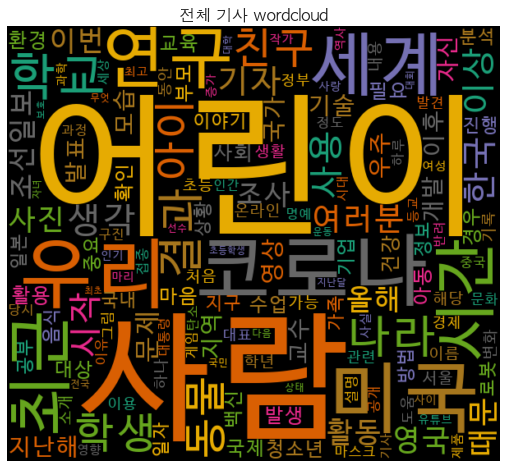

In [62]:
wordcloud(total_dtm['total_news'],'전체 기사 wordcloud')

#### N-gram
- n-gram은 n개의 연속적인 단어 나열을 의미
- 1-gram : unigram
- 2-gram : bigram
- 3-gram : trigram

In [64]:
def n_grams(tokens, n):
    l = len(tokens)
    return [tuple(tokens[i:i + n]) for i in range(l) if i + n <= l]

In [65]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

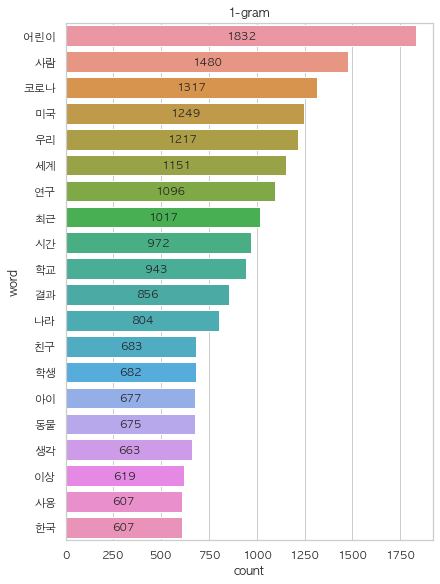

In [66]:
fig,ax=plt.subplots(1,1,figsize=(6,8),constrained_layout=True)
doc = news_df['news_article_mecab']

top_1_bigrams=get_top_ngram(doc,1)[:20]
a,b=map(list,zip(*top_1_bigrams))
word_count = pd.DataFrame({'word':a,'count':b})
sns.barplot(data= word_count,x='count',y='word').set_title('1-gram')

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.0f"%(width*1), xy=(left+width/2, bottom+height/2), ha='center', va='center',fontsize=11)

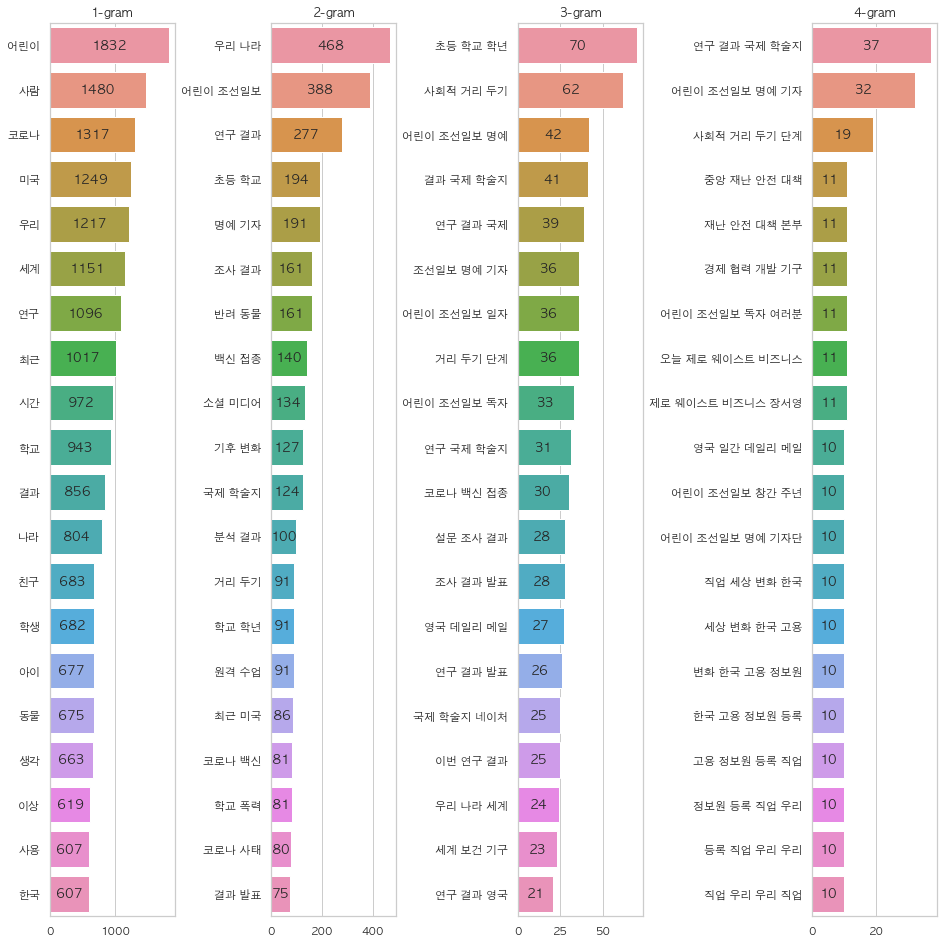

In [67]:
fig,ax=plt.subplots(1,4,figsize=(13,13),constrained_layout=True)
doc = news_df['news_article_mecab']

top_1_bigrams=get_top_ngram(doc,1)[:20]
x,y=map(list,zip(*top_1_bigrams))
word_count = pd.DataFrame({'word':x,'count':y})
sns.barplot(data= word_count,x=y,y=x,ax=ax[0]).set_title('1-gram')

top_2_bigrams=get_top_ngram(doc,2)[:20]
x,y=map(list,zip(*top_2_bigrams))
word_count = pd.DataFrame({'word':x,'count':y})
sns.barplot(data= word_count,x=y,y=x,ax=ax[1]).set_title('2-gram')

top_3_bigrams=get_top_ngram(doc,3)[:20]
x,y=map(list,zip(*top_3_bigrams))
word_count = pd.DataFrame({'word':x,'count':y})
sns.barplot(data= word_count,x=y,y=x,ax=ax[2]).set_title('3-gram')

top_4_bigrams=get_top_ngram(doc,4)[:20]
x,y=map(list,zip(*top_4_bigrams))
word_count = pd.DataFrame({'word':x,'count':y})
sns.barplot(data= word_count,x=y,y=x,ax=ax[3]).set_title('4-gram')

for i in range(len(ax)):
    for p in ax[i].patches:
        left, bottom, width, height = p.get_bbox().bounds
        ax[i].annotate("%.0f"%(width*1), xy=(left+width/2, bottom+height/2), ha='center', va='center',fontsize=13)

### 8.2 기사 별 CountVectorizer 확인

In [68]:
cv = CountVectorizer(analyzer='word')

count_list = cv.fit_transform(news_df['news_article_mecab'])
list_of_word = cv.get_feature_names()

text_dtm = pd.DataFrame(count_list.toarray(), columns=list_of_word)
text_dtm.index=news_df.news_title
text_dtm = text_dtm.reset_index()
text_dtm.head()

,news_title,가가,가가린,가감,가감산,가게,가격,가격대,가격표,가계,...,힌두스탄,힌즈,힌트,힐라,힐러리,힐리스,힐링,힐스,힘줄,힙합
0,우크라 전쟁통에도 교육은 계속돼야 한다 un도 지원사격,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ms가 뽑은 올해의 스타트업 키워드는.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,거대 벨리곰 보러 가자 잠실에 50만 명 발길,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,자가진단 키트 가격 내렸는데 반품 환불 안 되나요.,0,0,0,0,0,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,금융 인생서 꼭 필요한 공부 중요성 강조,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
text_dtm = text_dtm.transpose()

In [83]:
for index,text in enumerate(text_dtm.iloc[:, :10]):
    news_rank_dict = text_dtm[text][1:].sort_values(ascending=False)[:5].to_dict()
    print(text_dtm.iloc[0,index],news_rank_dict,sep='\n',end='\n----------\n')

우크라 전쟁통에도 교육은 계속돼야 한다 un도 지원사격
{'교육': 6, '어린이': 5, '우크라': 4, '아이': 3, '유엔': 2}
----------
ms가 뽑은 올해의 스타트업 키워드는.
{'트렌드': 4, '전자': 3, '올해': 3, '아시아': 3, '성장': 3}
----------
거대 벨리곰 보러 가자 잠실에 50만 명 발길
{'벨리': 3, '특성': 1, '롯데': 1, '의미': 1, '오리': 1}
----------
자가진단 키트 가격 내렸는데 반품 환불 안 되나요.
{'키트': 10, '가격': 9, '진단': 7, '학부모': 4, '검사': 3}
----------
금융 인생서 꼭 필요한 공부 중요성 강조
{'금융': 8, '교육': 3, '미국': 3, '주지사': 3, '인생': 2}
----------
인간이 본능적으로 끌리는 향은 바닐라 복숭아
{'냄새': 5, '연구': 2, '결과': 2, '선호도': 2, '바이올로지': 1}
----------
기자들의 수다
{'인간': 8, '여러분': 5, '가상': 4, '이번': 3, '사람': 3}
----------
실수로 누른 복권 버튼 122억 원 당첨 대박
{'복권': 7, '라케': 4, '당첨': 3, '그녀': 3, '남성': 2}
----------
어떤 모습도 사랑스러운 우리 가족.
{'모습': 6, '동물': 6, '서울': 6, '반려': 5, '사진': 3}
----------
오래 앉는 습관 안 좋아 숙제 시간 정해보세요
{'시간': 6, '행동': 4, '좌식': 4, '자세': 2, '캐나다': 2}
----------


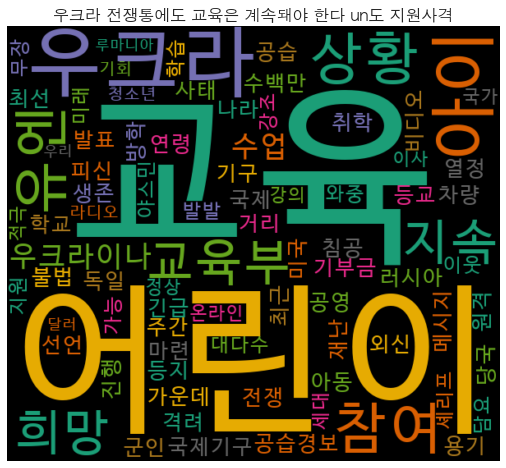

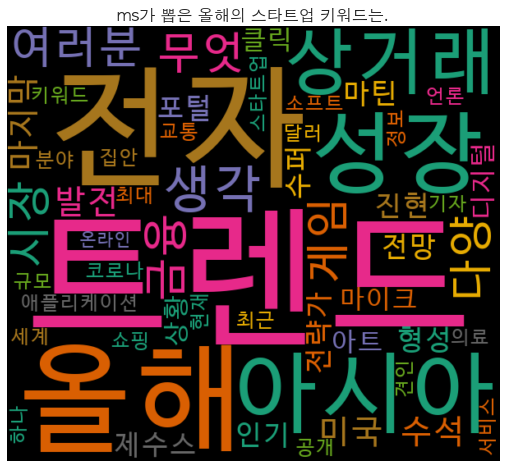

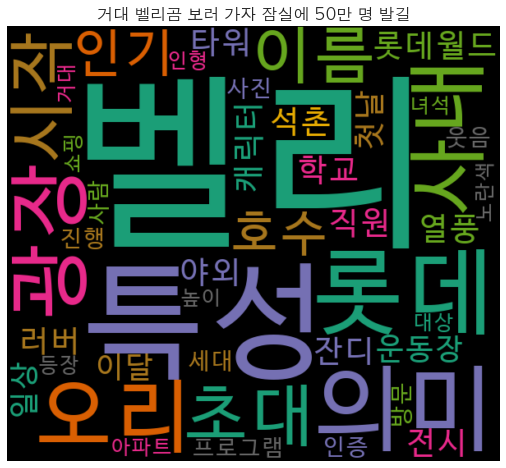

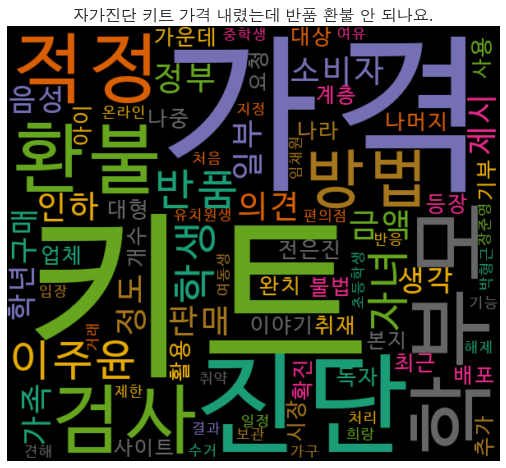

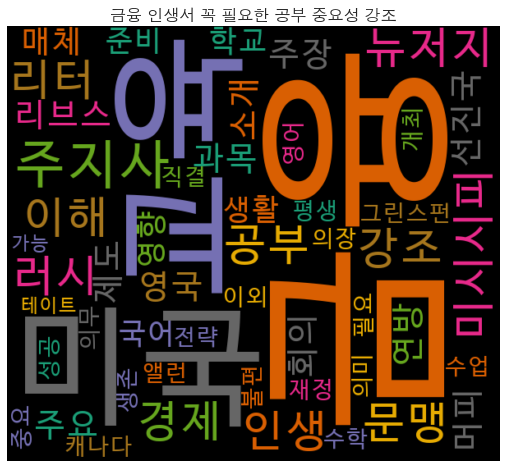

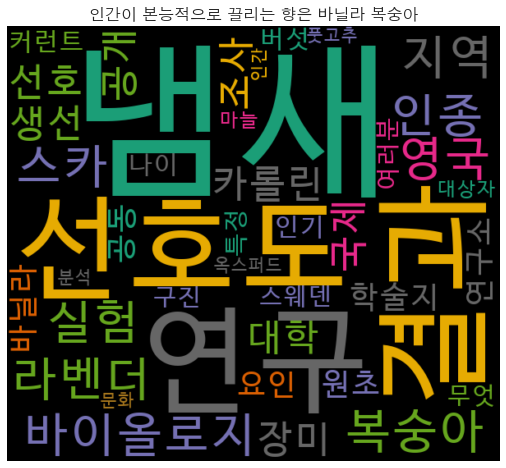

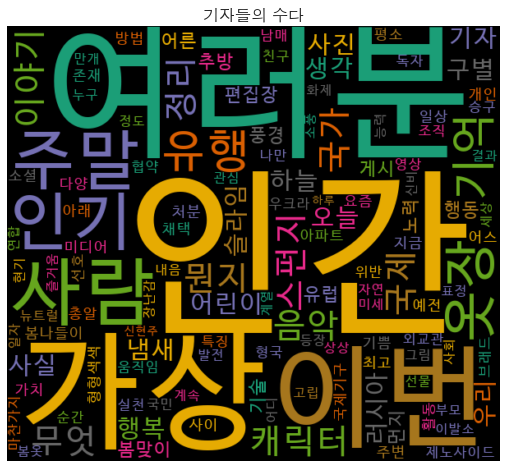

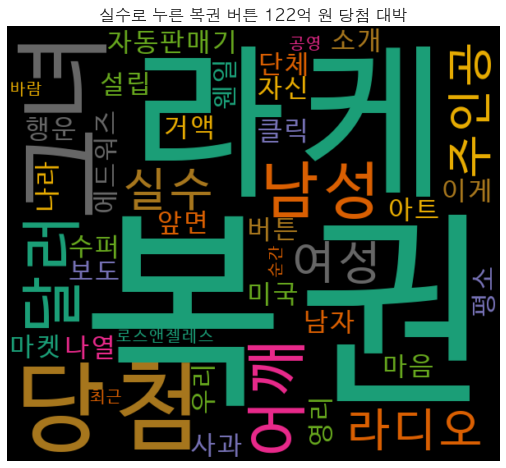

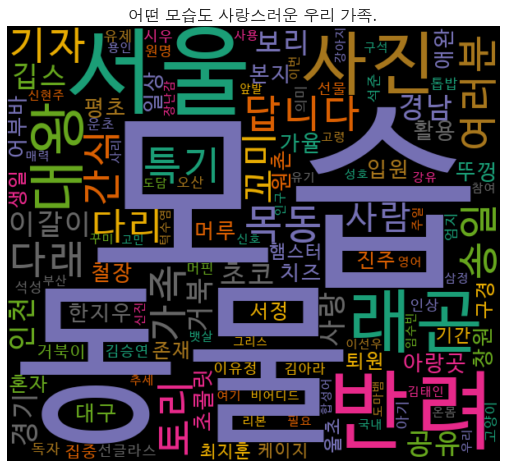

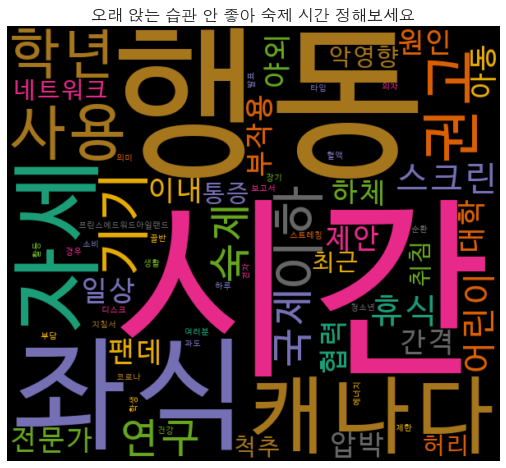

In [84]:
for index,text in enumerate(text_dtm.columns[0:10]):
    wordcloud(text_dtm[index][1:].sort_values(ascending=False),text_dtm.iloc[0,index])